# Comprehensive Alignment Evaluation

This notebook evaluates the trained vision-language alignment model against benchmarks from:
- **Freeze-Align**: Zero-shot classification, I2T/T2I retrieval
- **Matryoshka Multimodal Models**: MRL dimension analysis

**Output**: A comparison table summarizing all metrics.

## 1. Setup & Configuration

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from pathlib import Path
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from torchvision import transforms

# Add src to path
current_dir = Path.cwd()
if str(current_dir).endswith('notebooks'):
    root_dir = current_dir.parent
    os.chdir(root_dir)
    sys.path.insert(0, str(root_dir))
else:
    root_dir = current_dir

print(f'Working directory: {Path.cwd()}')

from src.config import load_config
from src.models.alignment import MultimodalAlignmentModel
from src.data.dataset_builder import build_image_datasets_from_parquet
from src.data.transforms import get_image_transforms
from src.evaluation.benchmark import AlignmentBenchmark
from src.evaluation.zero_shot import ZeroShotClassifier
from src.evaluation.templates import OPENAI_IMAGENET_TEMPLATES

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Working directory: /storage/ice1/1/0/vchopra37/projects/edge_glass/edge_glass_modular


/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/transformers/utils/hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


Using device: cuda


## 2. Load Configuration & Model

In [3]:
# Load config
config_path = root_dir / 'configs/pixmo_alignment.yaml'
print(f'Loading config from {config_path}...')
config = load_config(str(config_path))

# Initialize Model
print('Initializing model...')
model = MultimodalAlignmentModel(config)
model.to(device)
model.eval()
print('Model initialized.')

Loading config from /storage/ice1/1/0/vchopra37/projects/edge_glass/edge_glass_modular/configs/pixmo_alignment.yaml...
Initializing model...
DEBUG: Initial config num_key_value_heads: 4
DEBUG: Final config num_key_value_heads: 4


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

trainable params: 40,370,176 || all params: 7,655,986,688 || trainable%: 0.5273
Model initialized.


In [4]:
# Load Best Checkpoint
checkpoint_paths = {
    'pixmo_notebooks': root_dir / 'notebooks/checkpoints/pixmo_alignment/checkpoint_best.pt',
    'pixmo_outputs': root_dir / 'outputs/pixmo_alignment/checkpoint_best.pt',
    'perceiver_mrl': root_dir / 'notebooks/ddsp_scripts/checkpoints/perceiver_mrl_alignment/checkpoint_best.pt',
}

checkpoint_paths = {k: v for k, v in checkpoint_paths.items() if v.exists()}
if not checkpoint_paths:
    raise FileNotFoundError('No checkpoints found!')

# Use first available
ckpt_name = list(checkpoint_paths.keys())[0]
ckpt_path = checkpoint_paths[ckpt_name]
print(f'Using checkpoint: {ckpt_name} -> {ckpt_path}')

checkpoint = torch.load(ckpt_path, map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print('Checkpoint loaded.')

Using checkpoint: pixmo_notebooks -> /storage/ice1/1/0/vchopra37/projects/edge_glass/edge_glass_modular/notebooks/checkpoints/pixmo_alignment/checkpoint_best.pt
Checkpoint loaded.


## 3. Load Validation Data

In [5]:
image_size = config.dataset.image_size
val_transforms = get_image_transforms(image_size, is_training=False)

datasets = build_image_datasets_from_parquet(
    cfg=config,
    train_parquet_path=config.dataset.train_parquet,
    val_parquet_path=config.dataset.val_parquet,
    test_parquet_path=config.dataset.test_parquet,
    train_transforms=val_transforms,
    val_transforms=val_transforms,
)

val_dataset = datasets['val']
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
print(f'Validation samples: {len(val_dataset)}')
print(f'Validation batches: {len(val_loader)}')

/storage/ice1/1/0/vchopra37/projects/edge_glass/edge_glass_modular/src/data/dataset_builder.py:153: UserWarning: Removed 88 invalid images from /home/hice1/vchopra37/scratch/projects/edge_glass/dataset/final_dataset/pixmo/pixmo_train.parquet. Downstream loaders will skip them.
  warnings.warn(
/storage/ice1/1/0/vchopra37/projects/edge_glass/edge_glass_modular/src/data/dataset_builder.py:153: UserWarning: Removed 16 invalid images from /home/hice1/vchopra37/scratch/projects/edge_glass/dataset/final_dataset/pixmo/pixmo_val.parquet. Downstream loaders will skip them.
  warnings.warn(


Validation samples: 2984
Validation batches: 47


/storage/ice1/1/0/vchopra37/projects/edge_glass/edge_glass_modular/src/data/dataset_builder.py:153: UserWarning: Removed 20 invalid images from /home/hice1/vchopra37/scratch/projects/edge_glass/dataset/final_dataset/pixmo/pixmo_test.parquet. Downstream loaders will skip them.
  warnings.warn(


## 4. Extract Embeddings

In [6]:
@torch.no_grad()
def extract_embeddings(model, loader, device):
    vision_embs, text_embs, captions = [], [], []
    for batch in tqdm(loader, desc='Extracting embeddings'):
        images = batch['image'].to(device)
        texts = batch['text']
        
        # Filter dropped texts
        valid_idx = [i for i, t in enumerate(texts) if t]
        if not valid_idx:
            continue
        images = images[valid_idx]
        texts = [texts[i] for i in valid_idx]
        
        outputs = model(images=images, texts=texts, return_embeddings=True)
        v_emb = F.normalize(outputs.vision_emb, dim=-1)
        t_emb = F.normalize(outputs.text_emb, dim=-1)
        
        vision_embs.append(v_emb.cpu())
        text_embs.append(t_emb.cpu())
        captions.extend(texts)
    
    return torch.cat(vision_embs), torch.cat(text_embs), captions

vision_embs, text_embs, captions = extract_embeddings(model, val_loader, device)
print(f'Extracted {len(vision_embs)} embeddings of dim {vision_embs.shape[1]}')

Extracting embeddings:   0%|          | 0/47 [00:00<?, ?it/s]

/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Extracted 2984 embeddings of dim 4096


## 5. Retrieval Evaluation (Freeze-Align Style)

In [7]:
def compute_recall_at_k(query_embs, gallery_embs, ks=[1, 5, 10]):
    sim = query_embs @ gallery_embs.T
    n = sim.shape[0]
    max_k = max(ks)
    _, topk = sim.topk(max_k, dim=1)
    gt = torch.arange(n).unsqueeze(1).expand(-1, max_k)
    matches = (topk == gt)
    
    results = {}
    for k in ks:
        recall = matches[:, :k].any(dim=1).float().mean().item() * 100
        results[f'R@{k}'] = recall
    return results

print('Computing Retrieval Metrics...')
i2t_metrics = compute_recall_at_k(vision_embs, text_embs)
t2i_metrics = compute_recall_at_k(text_embs, vision_embs)

print(f"Image-to-Text: {i2t_metrics}")
print(f"Text-to-Image: {t2i_metrics}")

Computing Retrieval Metrics...
Image-to-Text: {'R@1': 18.83378028869629, 'R@5': 42.057639360427856, 'R@10': 54.65817451477051}
Text-to-Image: {'R@1': 20.006702840328217, 'R@5': 43.967828154563904, 'R@10': 56.03216886520386}


## 6. Zero-Shot Classification (Freeze-Align Style)

In [8]:
zs_datasets = ['CIFAR10', 'CIFAR100']
datasets_root = './data'

zs_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
])

zs_results = {}
benchmark = AlignmentBenchmark(model, device=str(device))

for ds_name in zs_datasets:
    try:
        print(f'\nLoading {ds_name}...')
        dataset = ZeroShotClassifier.load_dataset(ds_name.lower(), root_dir=datasets_root, split='test', transform=zs_transform)
        loader = DataLoader(dataset, batch_size=64, num_workers=4, shuffle=False)
        
        metrics = benchmark.evaluate_zero_shot(
            dataset_name=ds_name,
            class_names=dataset.classes,
            templates=OPENAI_IMAGENET_TEMPLATES,
            dataloader=loader
        )
        zs_results[ds_name] = metrics
    except Exception as e:
        print(f'Skipping {ds_name}: {e}')
        zs_results[ds_name] = {'top1': 0.0, 'top5': 0.0}


Loading CIFAR10...

Evaluating Zero-Shot on CIFAR10...


Building classifier:   0%|          | 0/10 [00:00<?, ?it/s]

Zero-shot evaluation:   0%|          | 0/157 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffe5da6f9c0>
Traceback (most recent call last):
  File "/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/local/pace-apps/spack/packages/linux-rhel9-x86_64_v3/gcc-11.3.1/python-3.12.5-5sase6atfv2x5tf7dy5x5sqfzyguhsia/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


  Top-1 Accuracy: 61.81%
  Top-5 Accuracy: 97.26%

Loading CIFAR100...

Evaluating Zero-Shot on CIFAR100...


Building classifier:   0%|          | 0/100 [00:00<?, ?it/s]

Zero-shot evaluation:   0%|          | 0/157 [00:00<?, ?it/s]

  Top-1 Accuracy: 22.40%
  Top-5 Accuracy: 60.01%


## 7. MRL Dimension Analysis (Matryoshka Style)

In [9]:
# Evaluate retrieval at different embedding dimensions
mrl_dims = [64, 128, 256, 512, 1024, 2048, 4096]
full_dim = vision_embs.shape[1]
mrl_dims = [d for d in mrl_dims if d <= full_dim]

mrl_results = {}
print('Evaluating MRL performance...')
for dim in tqdm(mrl_dims, desc='MRL Dims'):
    v_trunc = F.normalize(vision_embs[:, :dim], dim=-1)
    t_trunc = F.normalize(text_embs[:, :dim], dim=-1)
    
    i2t = compute_recall_at_k(v_trunc, t_trunc, ks=[1])
    mrl_results[dim] = i2t['R@1']

print('MRL Results:')
for dim, r1 in mrl_results.items():
    print(f'  Dim {dim}: R@1 = {r1:.2f}%')

Evaluating MRL performance...


MRL Dims:   0%|          | 0/7 [00:00<?, ?it/s]

MRL Results:
  Dim 64: R@1 = 5.86%
  Dim 128: R@1 = 9.72%
  Dim 256: R@1 = 13.27%
  Dim 512: R@1 = 15.88%
  Dim 1024: R@1 = 19.00%
  Dim 2048: R@1 = 19.37%
  Dim 4096: R@1 = 18.83%


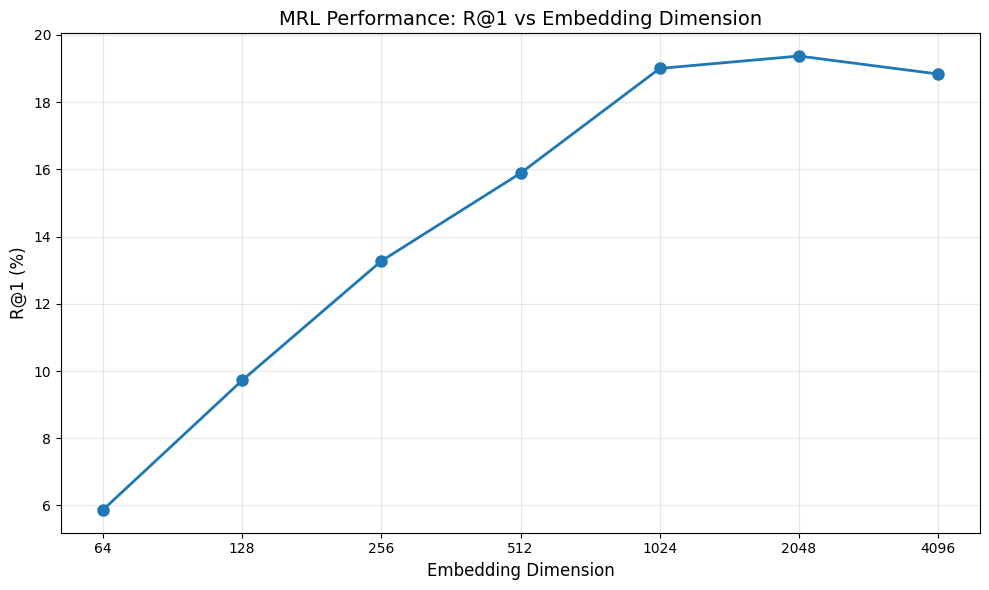

In [10]:
# Plot MRL Curve
plt.figure(figsize=(10, 6))
dims = list(mrl_results.keys())
r1s = list(mrl_results.values())
plt.plot(dims, r1s, 'o-', linewidth=2, markersize=8)
plt.xlabel('Embedding Dimension', fontsize=12)
plt.ylabel('R@1 (%)', fontsize=12)
plt.title('MRL Performance: R@1 vs Embedding Dimension', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xscale('log', base=2)
plt.xticks(dims, [str(d) for d in dims])
plt.tight_layout()
plt.savefig('outputs/mrl_curve.png', dpi=150)
plt.show()

## 8. Comparison Table

In [11]:
# Aggregate all metrics into a comparison table
comparison_data = {
    'Metric': [],
    'Value': [],
    'Category': []
}

# Retrieval
for k, v in i2t_metrics.items():
    comparison_data['Metric'].append(f'I2T {k}')
    comparison_data['Value'].append(f'{v:.2f}')
    comparison_data['Category'].append('Retrieval')

for k, v in t2i_metrics.items():
    comparison_data['Metric'].append(f'T2I {k}')
    comparison_data['Value'].append(f'{v:.2f}')
    comparison_data['Category'].append('Retrieval')

# Zero-Shot
for ds, metrics in zs_results.items():
    comparison_data['Metric'].append(f'{ds} Top-1')
    comparison_data['Value'].append(f"{metrics['top1']:.2f}")
    comparison_data['Category'].append('Zero-Shot')

# MRL Best
if mrl_results:
    best_dim = max(mrl_results, key=mrl_results.get)
    comparison_data['Metric'].append(f'MRL Best (dim={best_dim})')
    comparison_data['Value'].append(f'{mrl_results[best_dim]:.2f}')
    comparison_data['Category'].append('MRL')

comparison_df = pd.DataFrame(comparison_data)
print('\n' + '='*60)
print('COMPREHENSIVE EVALUATION RESULTS')
print('='*60)
print(comparison_df.to_string(index=False))
print('='*60)

# Save to CSV
comparison_df.to_csv('outputs/alignment_evaluation_results.csv', index=False)
print('\nResults saved to outputs/alignment_evaluation_results.csv')


COMPREHENSIVE EVALUATION RESULTS
             Metric Value  Category
            I2T R@1 18.83 Retrieval
            I2T R@5 42.06 Retrieval
           I2T R@10 54.66 Retrieval
            T2I R@1 20.01 Retrieval
            T2I R@5 43.97 Retrieval
           T2I R@10 56.03 Retrieval
      CIFAR10 Top-1 61.81 Zero-Shot
     CIFAR100 Top-1 22.40 Zero-Shot
MRL Best (dim=2048) 19.37       MRL

Results saved to outputs/alignment_evaluation_results.csv


## 9. Qualitative Retrieval Examples

In [12]:
def show_retrieval_example(idx, top_k=5):
    query = vision_embs[idx]
    scores = text_embs @ query
    top_scores, top_indices = scores.topk(top_k)
    
    print(f'\n--- Query {idx} ---')
    print(f'Ground Truth: {captions[idx][:100]}...')
    print('Top Retrieved:')
    for i, (score, ridx) in enumerate(zip(top_scores, top_indices)):
        marker = '[GT]' if ridx == idx else ''
        print(f'  {i+1}. [{score:.4f}] {captions[ridx][:80]}... {marker}')

# Show 3 random examples
np.random.seed(42)
for idx in np.random.choice(len(captions), 3, replace=False):
    show_retrieval_example(idx)


--- Query 2411 ---
Ground Truth: The photograph captures a vibrant, sunny day at the beach with a cloudless blue sky. The golden-brow...
Top Retrieved:
  1. [0.3748] The photograph captures an expansive horizontal landscape, set outdoors in what ... 
  2. [0.3666] This image captures a bustling courtyard or city square viewed from a balcony wi... 
  3. [0.3644] This image captures a tranquil bay area with a serene expanse of water reflectin... 
  4. [0.3633] This outdoor, landscape-mode color photograph exudes a distinct European charm. ... 
  5. [0.3616] This panoramic outdoor image captures a serene park scene from an elevated vanta... 

--- Query 1547 ---
Ground Truth: The image is a color photograph taken in portrait orientation depicting a laminated instruction shee...
Top Retrieved:
  1. [0.2568] This educational poster, predominantly in blue and brown hues with a substantial... 
  2. [0.2469] The image features various texts and elements arranged on a white background. At... 
 

## Summary

This notebook evaluated the alignment model with:
- **Retrieval**: Image-to-Text and Text-to-Image R@1, R@5, R@10
- **Zero-Shot Classification**: CIFAR-10, CIFAR-100 accuracy
- **MRL Analysis**: Performance across embedding dimensions

Results are saved to `outputs/alignment_evaluation_results.csv`.